In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import numpy as np
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxPHSurvivalAnalysis
from tqdm import tqdm
from utils.functions import EPE

eps = 0.1

def sample_list_decodable_failure(X, b1, b2):
    hazard = np.exp((X < 0.) * (b1 * X) + (X > 1. - eps) * (b2 * X))
    T = np.random.exponential(scale=1. / hazard)
    end_time = max(T) + 1.

    for i in range(len(X)):
        if (X[i] >= 0) & (X[i] <= 1. - eps):
            if np.random.rand() < 0.5:
                T[i] = 0. # + 0.01 * np.random.rand()
            else:
                T[i] = end_time # + 0.01 * np.random.randn()
    
    C = np.inf * np.ones(len(X))

    Y = np.empty(len(X), dtype=np.dtype([('failure', '?'), ('time', '<f8')]))
    for i in range(len(X)):
        Y[i] = (C[i] >= T[i], min(C[i], T[i]))

    X, Y = map(np.array, zip(*sorted(zip(X, Y), key=lambda x: x[1]['time'])))
    return X, Y

In [2]:
np.random.seed(0)

num_test_pts = 21
n = 4000
b1 = -4.
b2 = 25.

X = 2 * np.random.rand(n) - 1.
X, Y = sample_list_decodable_failure(X, b1, b2)

test_pts = np.linspace(-1., 1., num_test_pts)
print(test_pts)

epes = np.empty((num_test_pts, num_test_pts))
epes[:] = np.nan

for j in range(num_test_pts):
    for i in tqdm(range(j+1, num_test_pts)):
        lo = test_pts[j]
        hi = test_pts[i]
        region_ind = (X >= lo) & (X <= hi)

        beta_hat = CoxPHSurvivalAnalysis().fit(X[region_ind].reshape(-1, 1), Y[region_ind]).coef_
        epes[i, j] = EPE(X[region_ind].reshape(-1, 1), Y[region_ind], beta_hat)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


100%|██████████| 1/1 [00:00<00:00, 27.22it/s]
0it [00:00, ?it/s]


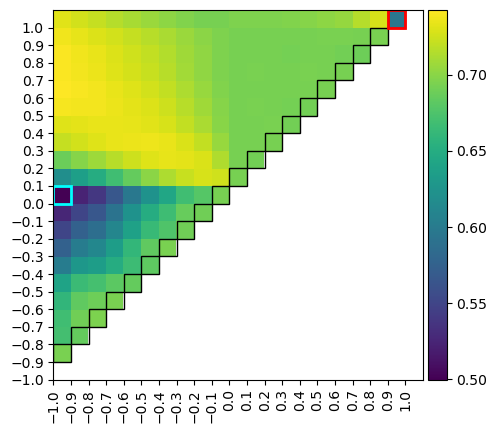

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

# masked_epes = np.ma.array(epes, mask = np.tril(np.ones(num_test_pts)))

im = ax.imshow(epes, origin='lower', extent=(-1, 1.1, -1, 1.1))
# im = ax.imshow(np.flip(epes, axis=0))
# ax.set_xticks(range(num_test_pts), labels=np.round(test_pts, 1), rotation='vertical')
# ax.set_yticks(range(num_test_pts), labels=np.round(test_pts, 1))

fig.colorbar(im, cax=cax, orientation='vertical')

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((test_pts[x], test_pts[y]), eps, eps, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for i in range(num_test_pts-1):
    highlight_cell(i, i+1, color="black", linewidth=1, ax=ax)

best_core_epe = np.inf
for j in range(num_test_pts-1):
    if epes[j+1, j] < best_core_epe:
        best_core_epe = epes[j+1, j]
        best_core_epe_ind = (j+1, j)
highlight_cell(best_core_epe_ind[1], best_core_epe_ind[0], color="red", linewidth=2, ax=ax)

best_epe = np.inf
for j in range(num_test_pts):
    for i in range(j+1, num_test_pts):
        if epes[i, j] < best_epe:
            best_epe = epes[i, j]
            best_epe_ind = (i, j)

highlight_cell(best_epe_ind[1], best_epe_ind[0], color="cyan", linewidth=2, ax=ax)
ax.set_xticks(test_pts)
ax.set_yticks(test_pts)
ax.tick_params(axis='x', labelrotation=90)
plt.savefig('fig_2.pdf')